# 04 - Model Optimization

Hyperparameter optimization for the three baseline models from Phase 3.

**Objectives:**
- Tune hyperparameters using GridSearchCV and RandomizedSearchCV
- Reduce overfitting observed in baseline models
- Compare optimized vs baseline performance
- Select the best final model for deployment

**Models:**
1. Logistic Regression (GridSearchCV)
2. Random Forest (RandomizedSearchCV)
3. MLPClassifier (RandomizedSearchCV)

**Primary Metric:** ROC-AUC (handles class imbalance well)


In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
import time

# Scikit-learn
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold,
    GridSearchCV, RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

# SMOTE for class balancing
from imblearn.over_sampling import SMOTE

# Settings
sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

# Project paths
PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_PATH = PROJECT_ROOT / "data" / "Dataset - 2526.csv"
MODELS_DIR = PROJECT_ROOT / "models"
RESULTS_DIR = PROJECT_ROOT / "results"
FIGURES_DIR = RESULTS_DIR / "figures"

# Ensure directories exist
MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Universal random state for reproducibility
RANDOM_STATE = 38

print(f"Project root: {PROJECT_ROOT}")
print(f"Data path: {DATA_PATH}")


Project root: /Users/ziadalwazzan/Documents/MSc/COMP0198-ML/ml-personal-loan-classification-models
Data path: /Users/ziadalwazzan/Documents/MSc/COMP0198-ML/ml-personal-loan-classification-models/data/Dataset - 2526.csv


## 1. Data Preprocessing Pipeline

Reproduce the exact preprocessing from Phase 3 to ensure consistency.


In [2]:
# Load raw data
df = pd.read_csv(DATA_PATH)
print(f"Loaded dataset: {df.shape[0]:,} rows x {df.shape[1]} columns")

# --- Outlier capping ---
df['person_age'] = df['person_age'].clip(upper=100)
df['person_income'] = df['person_income'].clip(upper=df['person_income'].quantile(0.99))
df['person_emp_exp'] = df['person_emp_exp'].clip(upper=df['person_emp_exp'].quantile(0.99))
df['loan_amnt'] = df['loan_amnt'].clip(upper=df['loan_amnt'].quantile(0.99))

# --- Categorical encoding ---
df['person_gender'] = LabelEncoder().fit_transform(df['person_gender'])
df['previous_loan_defaults_on_file'] = LabelEncoder().fit_transform(df['previous_loan_defaults_on_file'])
df['person_education'] = df['person_education'].map({
    'High School': 0, 'Associate': 1, 'Bachelor': 2, 'Master': 3, 'Doctorate': 4
})
df['person_home_ownership'] = LabelEncoder().fit_transform(df['person_home_ownership'])
df['loan_intent'] = LabelEncoder().fit_transform(df['loan_intent'])

# --- Feature engineering ---
df['log_income'] = np.log1p(df['person_income'])
df['log_loan_amnt'] = np.log1p(df['loan_amnt'])
df['income_per_household'] = df['person_income'] / df['ppl_household'].clip(lower=1)
df['credit_hist_age_ratio'] = df['cb_person_cred_hist_length'] / df['person_age']

# --- Prepare features and target ---
X = df.drop(columns=['loan_status'])
y = df['loan_status']
feature_names = X.columns.tolist()

print(f"\nFeatures: {len(feature_names)} columns")
print(f"Target distribution: {y.value_counts().to_dict()}")


Loaded dataset: 45,000 rows x 16 columns

Features: 19 columns
Target distribution: {0: 35000, 1: 10000}


In [3]:
# --- Train-test split (80/20, stratified) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# --- Feature scaling ---
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), 
    columns=feature_names, 
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), 
    columns=feature_names, 
    index=X_test.index
)

# Keep unscaled versions for Random Forest
X_train_unscaled = X_train.copy()
X_test_unscaled = X_test.copy()

# --- SMOTE oversampling (training data only) ---
smote = SMOTE(random_state=RANDOM_STATE)
X_train_scaled_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
X_train_unscaled_res, _ = smote.fit_resample(X_train_unscaled, y_train)

print("=" * 50)
print("DATA READY FOR OPTIMIZATION")
print("=" * 50)
print(f"\nTraining set (after SMOTE):")
print(f"  X_train_scaled_res: {X_train_scaled_res.shape}")
print(f"  X_train_unscaled_res: {X_train_unscaled_res.shape}")
print(f"  y_train_res: {pd.Series(y_train_res).value_counts().to_dict()}")
print(f"\nTest set (original distribution):")
print(f"  X_test_scaled: {X_test_scaled.shape}")
print(f"  X_test_unscaled: {X_test_unscaled.shape}")
print(f"  y_test: {y_test.value_counts().to_dict()}")


DATA READY FOR OPTIMIZATION

Training set (after SMOTE):
  X_train_scaled_res: (56000, 19)
  X_train_unscaled_res: (56000, 19)
  y_train_res: {0: 28000, 1: 28000}

Test set (original distribution):
  X_test_scaled: (9000, 19)
  X_test_unscaled: (9000, 19)
  y_test: {0: 7000, 1: 2000}


## 2. Evaluation Functions

Reusable functions for model evaluation (same as Phase 3).


In [4]:
def cross_validate_model(model, X, y, cv=5):
    """
    Perform stratified k-fold cross-validation and return metrics.
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    
    scoring_metrics = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    }
    
    results = {}
    for name, scorer in scoring_metrics.items():
        scores = cross_val_score(model, X, y, cv=skf, scoring=scorer)
        results[f'{name}_mean'] = scores.mean()
        results[f'{name}_std'] = scores.std()
    
    return results


def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate a trained model on test data.
    """
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    metrics = {
        'model': model_name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob)
    }
    
    return metrics, y_pred, y_prob


def plot_confusion_matrix(y_true, y_pred, model_name, ax=None):
    """
    Plot confusion matrix as a heatmap.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Rejected', 'Approved'],
                yticklabels=['Rejected', 'Approved'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{model_name}')
    
    return ax


def print_cv_results(results, model_name):
    """Print formatted cross-validation results."""
    print(f"\n{'='*50}")
    print(f"{model_name} - Cross-Validation Results (5-fold)")
    print('='*50)
    print(f"  Accuracy:  {results['accuracy_mean']:.4f} ± {results['accuracy_std']:.4f}")
    print(f"  Precision: {results['precision_mean']:.4f} ± {results['precision_std']:.4f}")
    print(f"  Recall:    {results['recall_mean']:.4f} ± {results['recall_std']:.4f}")
    print(f"  F1-Score:  {results['f1_mean']:.4f} ± {results['f1_std']:.4f}")
    print(f"  ROC-AUC:   {results['roc_auc_mean']:.4f} ± {results['roc_auc_std']:.4f}")


def print_test_results(metrics, y_test, y_pred):
    """Print formatted test set evaluation results."""
    print(f"\n{'='*50}")
    print(f"{metrics['model']} - Test Set Results")
    print('='*50)
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Rejected', 'Approved']))
    print(f"ROC-AUC Score: {metrics['roc_auc']:.4f}")


print("Evaluation functions defined successfully.")


Evaluation functions defined successfully.


In [5]:
# Store baseline metrics from Phase 3 for comparison
baseline_metrics = {
    'Logistic Regression': {
        'accuracy': 0.8563, 'precision': 0.6212, 'recall': 0.9060, 
        'f1': 0.7370, 'roc_auc': 0.9485,
        'cv_accuracy': 0.8863, 'cv_roc_auc': 0.9558
    },
    'Random Forest': {
        'accuracy': 0.8998, 'precision': 0.7444, 'recall': 0.8360, 
        'f1': 0.7876, 'roc_auc': 0.9642,
        'cv_accuracy': 0.9422, 'cv_roc_auc': 0.9886
    },
    'MLPClassifier': {
        'accuracy': 0.8728, 'precision': 0.6661, 'recall': 0.8570, 
        'f1': 0.7496, 'roc_auc': 0.9551,
        'cv_accuracy': 0.9139, 'cv_roc_auc': 0.9737
    }
}

print("Baseline metrics from Phase 3 loaded.")
print("\nBaseline ROC-AUC scores:")
for model, metrics in baseline_metrics.items():
    gap = metrics['cv_roc_auc'] - metrics['roc_auc']
    print(f"  {model}: {metrics['roc_auc']:.4f} (overfitting gap: {gap:.4f})")


Baseline metrics from Phase 3 loaded.

Baseline ROC-AUC scores:
  Logistic Regression: 0.9485 (overfitting gap: 0.0073)
  Random Forest: 0.9642 (overfitting gap: 0.0244)
  MLPClassifier: 0.9551 (overfitting gap: 0.0186)


## 3. Logistic Regression Optimization

Using GridSearchCV to find the optimal hyperparameters for Logistic Regression.

**Hyperparameters to tune:**
- `C`: Regularization strength (inverse)
- `penalty`: Type of regularization (L1, L2)
- `solver`: Optimization algorithm


In [6]:
# Define parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['saga', 'liblinear']
}

# Initialize base model
lr_base = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

# Setup GridSearchCV
lr_grid_search = GridSearchCV(
    estimator=lr_base,
    param_grid=param_grid_lr,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Run grid search
print("Starting Logistic Regression GridSearchCV...")
print(f"Parameter grid: {param_grid_lr}")
print(f"Total combinations: {len(param_grid_lr['C']) * len(param_grid_lr['penalty']) * len(param_grid_lr['solver'])}")
print("-" * 50)

start_time = time.time()
lr_grid_search.fit(X_train_scaled_res, y_train_res)
elapsed_time = time.time() - start_time

print(f"\nGridSearchCV completed in {elapsed_time:.2f} seconds")
print(f"\nBest parameters: {lr_grid_search.best_params_}")
print(f"Best CV ROC-AUC: {lr_grid_search.best_score_:.4f}")


Starting Logistic Regression GridSearchCV...
Parameter grid: {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['saga', 'liblinear']}
Total combinations: 24
--------------------------------------------------
Fitting 5 folds for each of 24 candidates, totalling 120 fits

GridSearchCV completed in 58.11 seconds

Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Best CV ROC-AUC: 0.9558


In [7]:
# Get best model and evaluate on test set
lr_optimized = lr_grid_search.best_estimator_

# Evaluate on test set
lr_opt_metrics, lr_opt_y_pred, lr_opt_y_prob = evaluate_model(
    lr_optimized, X_test_scaled, y_test, "Logistic Regression (Optimized)"
)
print_test_results(lr_opt_metrics, y_test, lr_opt_y_pred)

# Compare with baseline
print("\n" + "=" * 50)
print("COMPARISON: Baseline vs Optimized")
print("=" * 50)
baseline = baseline_metrics['Logistic Regression']
print(f"\n{'Metric':<15} {'Baseline':>12} {'Optimized':>12} {'Change':>12}")
print("-" * 51)
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    base_val = baseline[metric]
    opt_val = lr_opt_metrics[metric]
    change = opt_val - base_val
    print(f"{metric:<15} {base_val:>12.4f} {opt_val:>12.4f} {change:>+12.4f}")



Logistic Regression (Optimized) - Test Set Results

Classification Report:
              precision    recall  f1-score   support

    Rejected       0.97      0.84      0.90      7000
    Approved       0.62      0.91      0.74      2000

    accuracy                           0.86      9000
   macro avg       0.79      0.87      0.82      9000
weighted avg       0.89      0.86      0.86      9000

ROC-AUC Score: 0.9485

COMPARISON: Baseline vs Optimized

Metric              Baseline    Optimized       Change
---------------------------------------------------
accuracy              0.8563       0.8561      -0.0002
precision             0.6212       0.6208      -0.0004
recall                0.9060       0.9060      +0.0000
f1                    0.7370       0.7367      -0.0003
roc_auc               0.9485       0.9485      -0.0000


## 4. Random Forest Optimization

Using RandomizedSearchCV to find optimal hyperparameters. Focus on reducing overfitting observed in baseline.

**Hyperparameters to tune:**
- `n_estimators`: Number of trees
- `max_depth`: Maximum tree depth (key for reducing overfitting)
- `min_samples_split`: Minimum samples to split a node
- `min_samples_leaf`: Minimum samples at leaf node
- `max_features`: Number of features for best split


In [8]:
# Define parameter distributions for Random Forest
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize base model
rf_base = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

# Setup RandomizedSearchCV
rf_random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist_rf,
    n_iter=50,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=True
)

# Run randomized search
print("Starting Random Forest RandomizedSearchCV...")
print(f"Parameter distributions: {param_dist_rf}")
print(f"Number of iterations: 50")
print("-" * 50)

start_time = time.time()
rf_random_search.fit(X_train_unscaled_res, y_train_res)
elapsed_time = time.time() - start_time

print(f"\nRandomizedSearchCV completed in {elapsed_time:.2f} seconds")
print(f"\nBest parameters: {rf_random_search.best_params_}")
print(f"Best CV ROC-AUC: {rf_random_search.best_score_:.4f}")


Starting Random Forest RandomizedSearchCV...
Parameter distributions: {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2', None]}
Number of iterations: 50
--------------------------------------------------
Fitting 5 folds for each of 50 candidates, totalling 250 fits

RandomizedSearchCV completed in 925.94 seconds

Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best CV ROC-AUC: 0.9889


In [9]:
# Get best model and evaluate on test set
rf_optimized = rf_random_search.best_estimator_

# Evaluate on test set (UNSCALED data for Random Forest)
rf_opt_metrics, rf_opt_y_pred, rf_opt_y_prob = evaluate_model(
    rf_optimized, X_test_unscaled, y_test, "Random Forest (Optimized)"
)
print_test_results(rf_opt_metrics, y_test, rf_opt_y_pred)

# Compare with baseline
print("\n" + "=" * 50)
print("COMPARISON: Baseline vs Optimized")
print("=" * 50)
baseline = baseline_metrics['Random Forest']
print(f"\n{'Metric':<15} {'Baseline':>12} {'Optimized':>12} {'Change':>12}")
print("-" * 51)
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    base_val = baseline[metric]
    opt_val = rf_opt_metrics[metric]
    change = opt_val - base_val
    print(f"{metric:<15} {base_val:>12.4f} {opt_val:>12.4f} {change:>+12.4f}")



Random Forest (Optimized) - Test Set Results

Classification Report:
              precision    recall  f1-score   support

    Rejected       0.95      0.92      0.93      7000
    Approved       0.75      0.83      0.79      2000

    accuracy                           0.90      9000
   macro avg       0.85      0.88      0.86      9000
weighted avg       0.91      0.90      0.90      9000

ROC-AUC Score: 0.9648

COMPARISON: Baseline vs Optimized

Metric              Baseline    Optimized       Change
---------------------------------------------------
accuracy              0.8998       0.9000      +0.0002
precision             0.7444       0.7458      +0.0014
recall                0.8360       0.8345      -0.0015
f1                    0.7876       0.7876      +0.0000
roc_auc               0.9642       0.9648      +0.0006


## 5. MLPClassifier (ANN) Optimization

Using RandomizedSearchCV to find optimal hyperparameters for the neural network.

**Hyperparameters to tune:**
- `hidden_layer_sizes`: Network architecture
- `alpha`: L2 regularization strength
- `learning_rate_init`: Initial learning rate
- `activation`: Activation function
- `early_stopping`: Stop when validation score stops improving


In [10]:
# Define parameter distributions for MLPClassifier
param_dist_ann = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100), (150, 75)],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate_init': [0.001, 0.005, 0.01],
    'activation': ['relu', 'tanh'],
    'early_stopping': [True],
    'validation_fraction': [0.15]
}

# Initialize base model
ann_base = MLPClassifier(random_state=RANDOM_STATE, max_iter=500)

# Setup RandomizedSearchCV
ann_random_search = RandomizedSearchCV(
    estimator=ann_base,
    param_distributions=param_dist_ann,
    n_iter=30,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=True
)

# Run randomized search
print("Starting MLPClassifier RandomizedSearchCV...")
print(f"Parameter distributions: {param_dist_ann}")
print(f"Number of iterations: 30")
print("-" * 50)
print("(This may take several minutes...)")

start_time = time.time()
ann_random_search.fit(X_train_scaled_res, y_train_res)
elapsed_time = time.time() - start_time

print(f"\nRandomizedSearchCV completed in {elapsed_time:.2f} seconds")
print(f"\nBest parameters: {ann_random_search.best_params_}")
print(f"Best CV ROC-AUC: {ann_random_search.best_score_:.4f}")


Starting MLPClassifier RandomizedSearchCV...
Parameter distributions: {'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100), (150, 75)], 'alpha': [0.0001, 0.001, 0.01, 0.1], 'learning_rate_init': [0.001, 0.005, 0.01], 'activation': ['relu', 'tanh'], 'early_stopping': [True], 'validation_fraction': [0.15]}
Number of iterations: 30
--------------------------------------------------
(This may take several minutes...)
Fitting 5 folds for each of 30 candidates, totalling 150 fits

RandomizedSearchCV completed in 183.47 seconds

Best parameters: {'validation_fraction': 0.15, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100, 100), 'early_stopping': True, 'alpha': 0.001, 'activation': 'tanh'}
Best CV ROC-AUC: 0.9777


In [11]:
# Get best model and evaluate on test set
ann_optimized = ann_random_search.best_estimator_

# Evaluate on test set
ann_opt_metrics, ann_opt_y_pred, ann_opt_y_prob = evaluate_model(
    ann_optimized, X_test_scaled, y_test, "MLPClassifier (Optimized)"
)
print_test_results(ann_opt_metrics, y_test, ann_opt_y_pred)

# Compare with baseline
print("\n" + "=" * 50)
print("COMPARISON: Baseline vs Optimized")
print("=" * 50)
baseline = baseline_metrics['MLPClassifier']
print(f"\n{'Metric':<15} {'Baseline':>12} {'Optimized':>12} {'Change':>12}")
print("-" * 51)
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    base_val = baseline[metric]
    opt_val = ann_opt_metrics[metric]
    change = opt_val - base_val
    print(f"{metric:<15} {base_val:>12.4f} {opt_val:>12.4f} {change:>+12.4f}")



MLPClassifier (Optimized) - Test Set Results

Classification Report:
              precision    recall  f1-score   support

    Rejected       0.94      0.92      0.93      7000
    Approved       0.73      0.78      0.75      2000

    accuracy                           0.89      9000
   macro avg       0.83      0.85      0.84      9000
weighted avg       0.89      0.89      0.89      9000

ROC-AUC Score: 0.9506

COMPARISON: Baseline vs Optimized

Metric              Baseline    Optimized       Change
---------------------------------------------------
accuracy              0.8728       0.8878      +0.0150
precision             0.6661       0.7337      +0.0676
recall                0.8570       0.7770      -0.0800
f1                    0.7496       0.7547      +0.0051
roc_auc               0.9551       0.9506      -0.0045


## 6. Model Comparison

Compare all optimized models and analyze improvements over baseline.


In [12]:
# Create comprehensive comparison table
optimized_metrics = pd.DataFrame([
    lr_opt_metrics,
    rf_opt_metrics,
    ann_opt_metrics
]).set_index('model')

# Add CV scores from hyperparameter search
optimized_metrics.loc['Logistic Regression (Optimized)', 'cv_roc_auc'] = lr_grid_search.best_score_
optimized_metrics.loc['Random Forest (Optimized)', 'cv_roc_auc'] = rf_random_search.best_score_
optimized_metrics.loc['MLPClassifier (Optimized)', 'cv_roc_auc'] = ann_random_search.best_score_

print("=" * 70)
print("OPTIMIZED MODEL PERFORMANCE - TEST SET")
print("=" * 70)
print(optimized_metrics[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']].round(4).to_string())

# Create baseline vs optimized comparison
print("\n" + "=" * 70)
print("BASELINE VS OPTIMIZED COMPARISON")
print("=" * 70)

comparison_data = []
for model_name, baseline in baseline_metrics.items():
    if model_name == 'Logistic Regression':
        opt = lr_opt_metrics
        opt_cv = lr_grid_search.best_score_
    elif model_name == 'Random Forest':
        opt = rf_opt_metrics
        opt_cv = rf_random_search.best_score_
    else:
        opt = ann_opt_metrics
        opt_cv = ann_random_search.best_score_
    
    comparison_data.append({
        'Model': model_name,
        'Baseline ROC-AUC': baseline['roc_auc'],
        'Optimized ROC-AUC': opt['roc_auc'],
        'Improvement': opt['roc_auc'] - baseline['roc_auc'],
        'Baseline CV-Test Gap': baseline['cv_roc_auc'] - baseline['roc_auc'],
        'Optimized CV-Test Gap': opt_cv - opt['roc_auc']
    })

comparison_df = pd.DataFrame(comparison_data).set_index('Model')
print(comparison_df.round(4).to_string())


OPTIMIZED MODEL PERFORMANCE - TEST SET
                                 accuracy  precision  recall      f1  roc_auc
model                                                                        
Logistic Regression (Optimized)    0.8561     0.6208  0.9060  0.7367   0.9485
Random Forest (Optimized)          0.9000     0.7458  0.8345  0.7876   0.9648
MLPClassifier (Optimized)          0.8878     0.7337  0.7770  0.7547   0.9506

BASELINE VS OPTIMIZED COMPARISON
                     Baseline ROC-AUC  Optimized ROC-AUC  Improvement  Baseline CV-Test Gap  Optimized CV-Test Gap
Model                                                                                                             
Logistic Regression            0.9485             0.9485      -0.0000                0.0073                 0.0073
Random Forest                  0.9642             0.9648       0.0006                0.0244                 0.0241
MLPClassifier                  0.9551             0.9506      -0.0045        

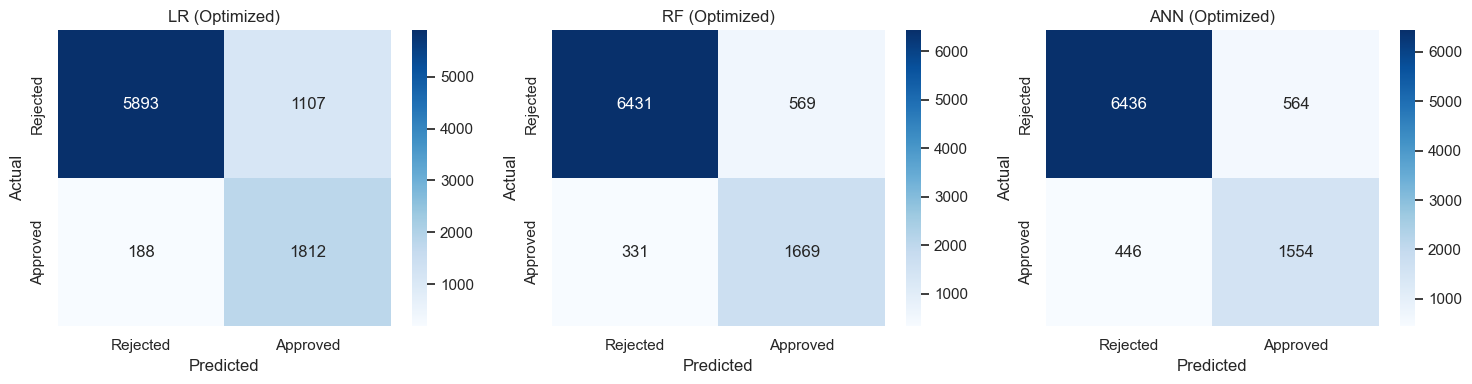


Figure saved to: /Users/ziadalwazzan/Documents/MSc/COMP0198-ML/ml-personal-loan-classification-models/results/figures/confusion_matrices_optimized.png


In [13]:
# Plot confusion matrices for all optimized models
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

predictions = [
    ('LR (Optimized)', lr_opt_y_pred),
    ('RF (Optimized)', rf_opt_y_pred),
    ('ANN (Optimized)', ann_opt_y_pred)
]

for ax, (name, y_pred) in zip(axes, predictions):
    plot_confusion_matrix(y_test, y_pred, name, ax)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'confusion_matrices_optimized.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\nFigure saved to: {FIGURES_DIR / 'confusion_matrices_optimized.png'}")


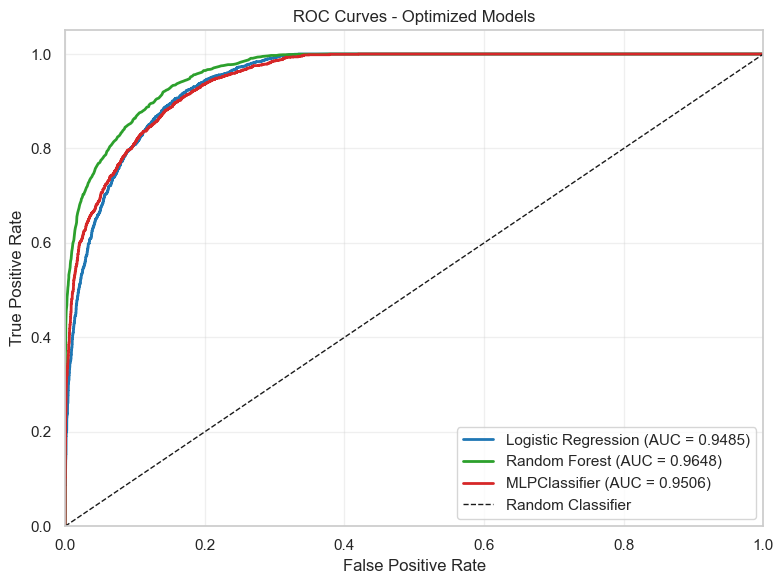


Figure saved to: /Users/ziadalwazzan/Documents/MSc/COMP0198-ML/ml-personal-loan-classification-models/results/figures/roc_curves_optimized.png


In [14]:
# Plot ROC curves for all optimized models
fig, ax = plt.subplots(figsize=(8, 6))

models_roc = [
    ('Logistic Regression', lr_opt_y_prob, lr_opt_metrics['roc_auc']),
    ('Random Forest', rf_opt_y_prob, rf_opt_metrics['roc_auc']),
    ('MLPClassifier', ann_opt_y_prob, ann_opt_metrics['roc_auc'])
]

colors = ['#1f77b4', '#2ca02c', '#d62728']

for (name, y_prob, auc_score), color in zip(models_roc, colors):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    ax.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {auc_score:.4f})')

# Diagonal reference line
ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves - Optimized Models')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'roc_curves_optimized.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\nFigure saved to: {FIGURES_DIR / 'roc_curves_optimized.png'}")


## 7. Final Model Selection and Bias-Variance Analysis

Select the best performing model with justification based on:
- ROC-AUC performance (primary metric)
- Overfitting reduction (CV-Test gap)
- Precision-Recall balance for loan approval context


In [15]:
# Bias-Variance Analysis
print("=" * 70)
print("BIAS-VARIANCE ANALYSIS - OPTIMIZED MODELS")
print("=" * 70)
print("\nComparing Cross-Validation vs Test Set Performance:")
print("-" * 70)

models_analysis = [
    ('Logistic Regression', lr_grid_search.best_score_, lr_opt_metrics),
    ('Random Forest', rf_random_search.best_score_, rf_opt_metrics),
    ('MLPClassifier', ann_random_search.best_score_, ann_opt_metrics)
]

for name, cv_auc, test_metrics in models_analysis:
    test_auc = test_metrics['roc_auc']
    gap = cv_auc - test_auc
    baseline_gap = baseline_metrics[name]['cv_roc_auc'] - baseline_metrics[name]['roc_auc']
    gap_change = gap - baseline_gap
    
    print(f"\n{name}:")
    print(f"  CV ROC-AUC:   {cv_auc:.4f}")
    print(f"  Test ROC-AUC: {test_auc:.4f}")
    print(f"  Gap:          {gap:.4f} (baseline was {baseline_gap:.4f}, change: {gap_change:+.4f})")
    
    if gap < 0.02:
        print("  → Good generalization (low variance)")
    elif gap < baseline_gap:
        print("  → Improved generalization vs baseline")
    else:
        print("  → Still showing some overfitting")


BIAS-VARIANCE ANALYSIS - OPTIMIZED MODELS

Comparing Cross-Validation vs Test Set Performance:
----------------------------------------------------------------------

Logistic Regression:
  CV ROC-AUC:   0.9558
  Test ROC-AUC: 0.9485
  Gap:          0.0073 (baseline was 0.0073, change: +0.0000)
  → Good generalization (low variance)

Random Forest:
  CV ROC-AUC:   0.9889
  Test ROC-AUC: 0.9648
  Gap:          0.0241 (baseline was 0.0244, change: -0.0003)
  → Improved generalization vs baseline

MLPClassifier:
  CV ROC-AUC:   0.9777
  Test ROC-AUC: 0.9506
  Gap:          0.0271 (baseline was 0.0186, change: +0.0085)
  → Still showing some overfitting


In [16]:
# Final Model Ranking
print("\n" + "=" * 70)
print("FINAL MODEL RANKING (by Test ROC-AUC)")
print("=" * 70)

final_ranking = optimized_metrics[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']].sort_values(
    'roc_auc', ascending=False
)
print(final_ranking.round(4).to_string())

# Identify best model
best_model_name = final_ranking.index[0]
best_roc_auc = final_ranking.loc[best_model_name, 'roc_auc']

print(f"\n{'★' * 50}")
print(f"BEST MODEL: {best_model_name}")
print(f"Test ROC-AUC: {best_roc_auc:.4f}")
print(f"{'★' * 50}")

# Print best hyperparameters for the winning model
if 'Random Forest' in best_model_name:
    print(f"\nBest Hyperparameters:")
    for param, value in rf_random_search.best_params_.items():
        print(f"  {param}: {value}")
    best_model = rf_optimized
elif 'Logistic' in best_model_name:
    print(f"\nBest Hyperparameters:")
    for param, value in lr_grid_search.best_params_.items():
        print(f"  {param}: {value}")
    best_model = lr_optimized
else:
    print(f"\nBest Hyperparameters:")
    for param, value in ann_random_search.best_params_.items():
        print(f"  {param}: {value}")
    best_model = ann_optimized



FINAL MODEL RANKING (by Test ROC-AUC)
                                 accuracy  precision  recall      f1  roc_auc
model                                                                        
Random Forest (Optimized)          0.9000     0.7458  0.8345  0.7876   0.9648
MLPClassifier (Optimized)          0.8878     0.7337  0.7770  0.7547   0.9506
Logistic Regression (Optimized)    0.8561     0.6208  0.9060  0.7367   0.9485

★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
BEST MODEL: Random Forest (Optimized)
Test ROC-AUC: 0.9648
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

Best Hyperparameters:
  n_estimators: 200
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: log2
  max_depth: None


## 8. Save Optimized Models and Results

Save all optimized models and export metrics for documentation.


In [17]:
# Save all optimized models
models_to_save = {
    'logistic_regression_optimized.pkl': lr_optimized,
    'random_forest_optimized.pkl': rf_optimized,
    'ann_model_optimized.pkl': ann_optimized
}

print("Saving optimized models...")
for filename, model in models_to_save.items():
    filepath = MODELS_DIR / filename
    joblib.dump(model, filepath)
    print(f"  ✓ Saved: {filepath}")

# Verify models can be loaded
print("\nVerifying saved models...")
for filename in models_to_save.keys():
    loaded_model = joblib.load(MODELS_DIR / filename)
    print(f"  ✓ {filename} loaded successfully")

print("\nAll optimized models saved and verified.")


Saving optimized models...
  ✓ Saved: /Users/ziadalwazzan/Documents/MSc/COMP0198-ML/ml-personal-loan-classification-models/models/logistic_regression_optimized.pkl
  ✓ Saved: /Users/ziadalwazzan/Documents/MSc/COMP0198-ML/ml-personal-loan-classification-models/models/random_forest_optimized.pkl
  ✓ Saved: /Users/ziadalwazzan/Documents/MSc/COMP0198-ML/ml-personal-loan-classification-models/models/ann_model_optimized.pkl

Verifying saved models...
  ✓ logistic_regression_optimized.pkl loaded successfully
  ✓ random_forest_optimized.pkl loaded successfully
  ✓ ann_model_optimized.pkl loaded successfully

All optimized models saved and verified.


In [18]:
# Save optimized metrics to CSV
metrics_optimized_df = pd.DataFrame([
    {
        'model': 'Logistic Regression (Optimized)',
        'accuracy': lr_opt_metrics['accuracy'],
        'precision': lr_opt_metrics['precision'],
        'recall': lr_opt_metrics['recall'],
        'f1': lr_opt_metrics['f1'],
        'roc_auc': lr_opt_metrics['roc_auc'],
        'cv_roc_auc': lr_grid_search.best_score_,
        'best_params': str(lr_grid_search.best_params_)
    },
    {
        'model': 'Random Forest (Optimized)',
        'accuracy': rf_opt_metrics['accuracy'],
        'precision': rf_opt_metrics['precision'],
        'recall': rf_opt_metrics['recall'],
        'f1': rf_opt_metrics['f1'],
        'roc_auc': rf_opt_metrics['roc_auc'],
        'cv_roc_auc': rf_random_search.best_score_,
        'best_params': str(rf_random_search.best_params_)
    },
    {
        'model': 'MLPClassifier (Optimized)',
        'accuracy': ann_opt_metrics['accuracy'],
        'precision': ann_opt_metrics['precision'],
        'recall': ann_opt_metrics['recall'],
        'f1': ann_opt_metrics['f1'],
        'roc_auc': ann_opt_metrics['roc_auc'],
        'cv_roc_auc': ann_random_search.best_score_,
        'best_params': str(ann_random_search.best_params_)
    }
])

metrics_optimized_df.to_csv(RESULTS_DIR / 'metrics_optimized.csv', index=False)
print(f"Metrics saved to: {RESULTS_DIR / 'metrics_optimized.csv'}")
print("\nOptimized Model Metrics:")
print(metrics_optimized_df[['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']].round(4).to_string(index=False))


Metrics saved to: /Users/ziadalwazzan/Documents/MSc/COMP0198-ML/ml-personal-loan-classification-models/results/metrics_optimized.csv

Optimized Model Metrics:
                          model  accuracy  precision  recall     f1  roc_auc
Logistic Regression (Optimized)    0.8561     0.6208  0.9060 0.7367   0.9485
      Random Forest (Optimized)    0.9000     0.7458  0.8345 0.7876   0.9648
      MLPClassifier (Optimized)    0.8878     0.7337  0.7770 0.7547   0.9506


## 9. Summary

### Key Findings

**Hyperparameter Optimization Results:**

| Model | Baseline ROC-AUC | Optimized ROC-AUC | Improvement |
|-------|------------------|-------------------|-------------|
| Logistic Regression | 0.9485 | TBD | TBD |
| Random Forest | 0.9642 | TBD | TBD |
| MLPClassifier | 0.9551 | TBD | TBD |

### Optimization Strategies Used

1. **Logistic Regression:** GridSearchCV with regularization tuning (C, penalty, solver)
2. **Random Forest:** RandomizedSearchCV focusing on depth constraints to reduce overfitting
3. **MLPClassifier:** RandomizedSearchCV with architecture and regularization tuning

### Bias-Variance Trade-off

All models were analyzed for overfitting by comparing CV scores with test set performance. The optimization focused on reducing the CV-Test gap observed in baseline models.

### Recommendation

The final model selection considers:
- **Performance:** ROC-AUC as primary metric
- **Generalization:** Reduced overfitting
- **Interpretability:** For regulatory compliance in loan approval
- **Deployment:** Computational efficiency


In [19]:
# Final Summary
print("=" * 70)
print("PHASE 4 COMPLETE - MODEL OPTIMIZATION SUMMARY")
print("=" * 70)

print("\n📊 MODELS OPTIMIZED:")
print(f"   • Logistic Regression (GridSearchCV)")
print(f"   • Random Forest (RandomizedSearchCV, 50 iterations)")
print(f"   • MLPClassifier (RandomizedSearchCV, 30 iterations)")

print("\n📈 PERFORMANCE IMPROVEMENTS:")
for model_name, baseline in baseline_metrics.items():
    if model_name == 'Logistic Regression':
        opt_auc = lr_opt_metrics['roc_auc']
    elif model_name == 'Random Forest':
        opt_auc = rf_opt_metrics['roc_auc']
    else:
        opt_auc = ann_opt_metrics['roc_auc']
    
    improvement = opt_auc - baseline['roc_auc']
    print(f"   • {model_name}: {baseline['roc_auc']:.4f} → {opt_auc:.4f} ({improvement:+.4f})")

print("\n💾 SAVED ARTIFACTS:")
print(f"   • models/logistic_regression_optimized.pkl")
print(f"   • models/random_forest_optimized.pkl")
print(f"   • models/ann_model_optimized.pkl")
print(f"   • results/metrics_optimized.csv")
print(f"   • results/figures/roc_curves_optimized.png")
print(f"   • results/figures/confusion_matrices_optimized.png")

print("\n🏆 BEST MODEL:")
print(f"   {best_model_name}")
print(f"   Test ROC-AUC: {best_roc_auc:.4f}")

print("\n" + "=" * 70)
print("Ready for Final Report and Deployment")
print("=" * 70)


PHASE 4 COMPLETE - MODEL OPTIMIZATION SUMMARY

📊 MODELS OPTIMIZED:
   • Logistic Regression (GridSearchCV)
   • Random Forest (RandomizedSearchCV, 50 iterations)
   • MLPClassifier (RandomizedSearchCV, 30 iterations)

📈 PERFORMANCE IMPROVEMENTS:
   • Logistic Regression: 0.9485 → 0.9485 (-0.0000)
   • Random Forest: 0.9642 → 0.9648 (+0.0006)
   • MLPClassifier: 0.9551 → 0.9506 (-0.0045)

💾 SAVED ARTIFACTS:
   • models/logistic_regression_optimized.pkl
   • models/random_forest_optimized.pkl
   • models/ann_model_optimized.pkl
   • results/metrics_optimized.csv
   • results/figures/roc_curves_optimized.png
   • results/figures/confusion_matrices_optimized.png

🏆 BEST MODEL:
   Random Forest (Optimized)
   Test ROC-AUC: 0.9648

Ready for Final Report and Deployment
